#**OPIM 5512 Team 2 Project (FALL 2021): Insurance Cross-Sell Prediction**

#Introduction and Background
For our project we decided to predict whether or not an existing health insurance policyholder is likely to purchase an automobile policy. Cross-selling is something that can be applied across many different industries and the most successful companies know how to do it well. For example, Amazon will recommend products that are complementary to the one a company is already purchasing. This is a very powerful sales tool as it allows the company to leverage existing business to drive more sales and better serve their variety of needs.

##Data
https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

#Importing Modules and Data Retrieval

In [ ]:
# #Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#pip install imblearn  #This library is for imabalanced datasets
#pip install dtreeviz

In [ ]:
#Import packages for data exploration and cleanup
import pandas as pd #importing pandas module to work on data frames
import numpy as np #importing numpy module to work on arrays
import seaborn as sns #importing seaborn module to work on visualizations
from matplotlib import pyplot as plt #importing matplotlib to work on visualizations
from scipy.stats import randint #stat module
from scipy.stats import uniform 

##Importing necessary Scikit learn packages for Sampling and Modeling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score,accuracy_score,confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report

In [ ]:
#Importing modules for sampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,confusion_matrix,r2_score,accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB



import graphviz

In [1]:
#Import dataset
URL = 'https://drive.google.com/file/d/1ZtJsDNfnGywtVSGK9UpyvcVkY27IWvbM/view?usp=sharing' #the url for data file

fixed_path = 'https://drive.google.com/uc?export=download&id='  # url format to down load

file_path = URL.split('/')[-2] #fetching unique identifier (last part) from the URL

d = pd.read_csv(fixed_path + file_path) #reading data into CSV file and storing it into a data frame


NameError: ignored

#Data Dictionary & Statistics

Our data is comprised of 12 fields and 381,109 records:
* id:	Unique ID for the customer
* Gender:	Gender of the customer
* Age:	Age of the customer
* Driving_License:	0 : Customer does not have DL, 1 : Customer already has DL
* Region_Code:	Unique code for the region of the customer
* Previously_Insured:	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* Vehicle_Age:	Age of the Vehicle
* Vehicle_Damage:	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* Annual_Premium:	The amount customer needs to pay as premium in the year
* PolicySalesChannel:	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* Vintage:	Number of Days, Customer has been associated with the company
* Response:	1 : Customer is interested, 0 : Customer is not interested - **Target**

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


**The below statistics are mainly useful for the continuos variable columns. By ey balling we can notice that Annual_premium column has outliers. The value from 75th percentile to max has increased drastically from 39400 to 540165. The Age column would have few outliers**

In [ ]:
d.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


**We can see a sample data by using head function in pandas.**

In [ ]:
#View first 5 rows of data
d.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


**The following count plot shows the class distribution of target variable "Response". It is evident that the majority class is 0. We should apply sampling techniques to balance the dataset**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


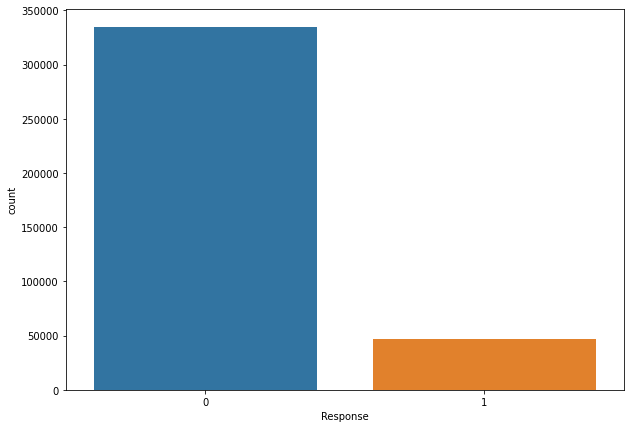

In [ ]:
figs, axes = plt.subplots(figsize=(10,7)) #Configuring the plot size

plot = sns.countplot(d['Response']) #applying count plot function from seaborn library

plt.show() #Displaying the plot

#Data Pre-processing and Exploration

##Checking for null values
The first step during pre-processing is to check if we have any Null values. We were very pleased to see that our data did not have any null values to impute.

In [ ]:
d.isnull().sum() #To check sum of null values in each column

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

##Checking the data for outliers
As we have already discussed, we can see from the below graphs that Annual premium has outliers. For the Age coulmn, there are few records out of the quartile for class 1 but they cannot be considered as outliers. For this project, we identified any value as a outliers when it is above or below 1.5 times of inter-quartile range


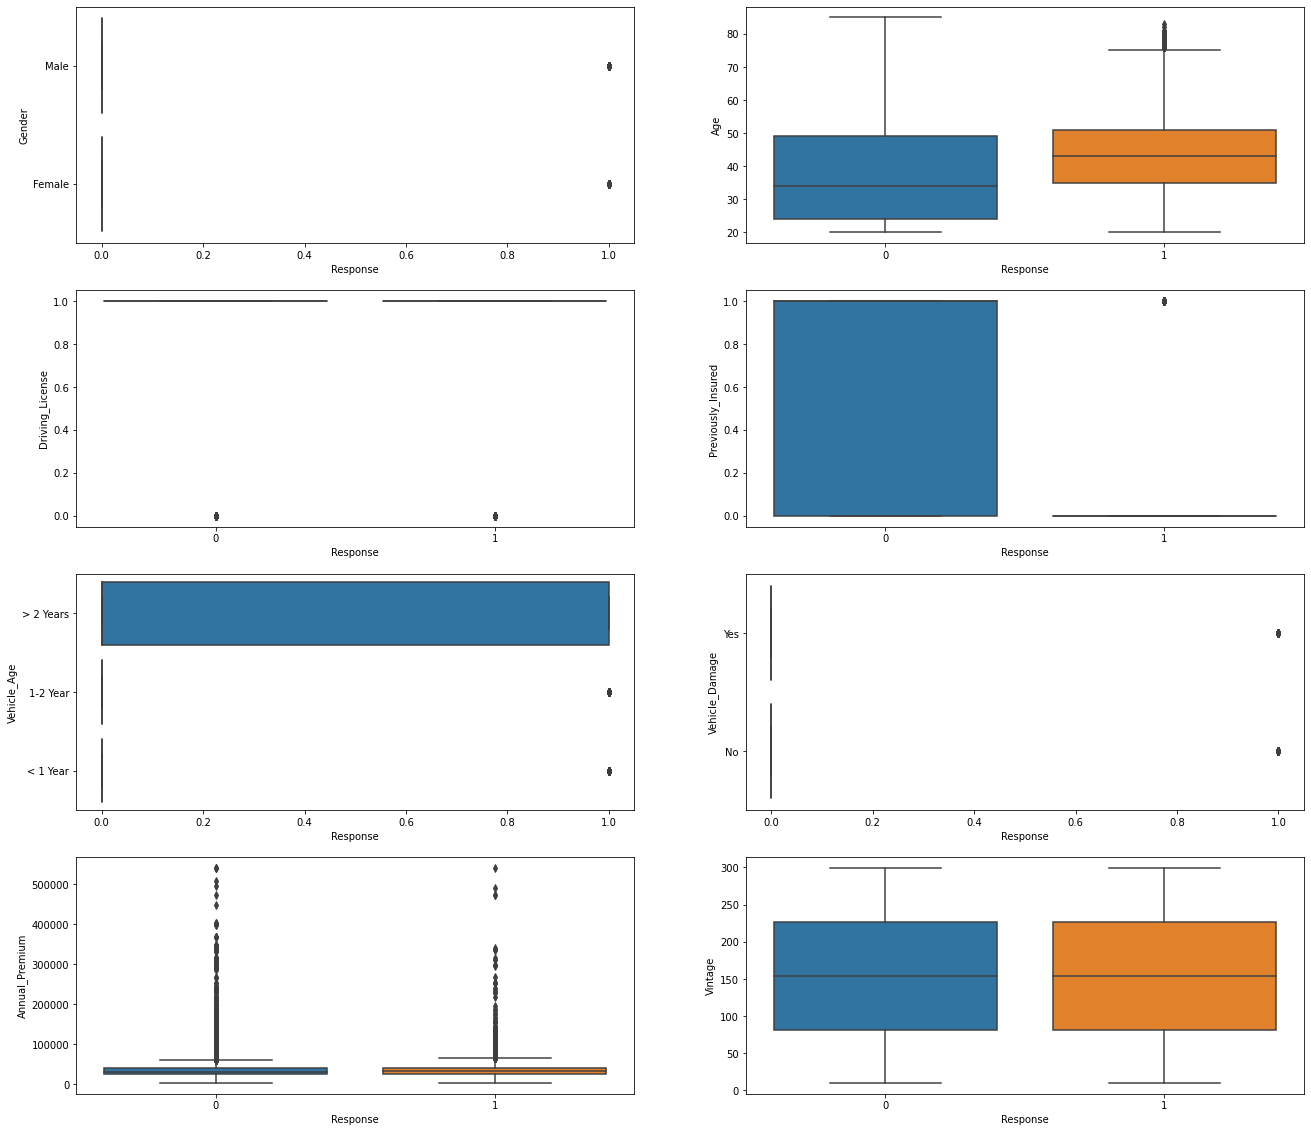

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(22,20)) #Preparing 8 sub plots with size 22, 20 

#Box plots for each column against target variable 'Response'
sns.boxplot(ax=axes[0, 0], data=d, x='Response', y='Gender')
sns.boxplot(ax=axes[0, 1], data=d, x='Response', y='Age')
sns.boxplot(ax=axes[1, 0], data=d, x='Response', y='Driving_License')
sns.boxplot(ax=axes[1, 1], data=d, x='Response', y='Previously_Insured')
sns.boxplot(ax=axes[2, 0], data=d, x='Response', y='Vehicle_Age')
sns.boxplot(ax=axes[2, 1], data=d, x='Response', y='Vehicle_Damage')
sns.boxplot(ax=axes[3, 0], data=d, x='Response', y='Annual_Premium')
sns.boxplot(ax=axes[3, 1], data=d, x='Response', y='Vintage')

**The following function determines the lower and upper bound**

In [ ]:
def outlier_treatment(datacolumn):
 sorted(datacolumn)
 Q1,Q3 = np.percentile(datacolumn , [25,75]) # calculates the values at 25th and 75th quartile ranges
 IQR = Q3 - Q1
 lower_range = Q1 - (1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 return lower_range,upper_range

In [ ]:
lowerbound,upperbound = outlier_treatment(d.Annual_Premium) #Calculating lower bound and upper bound values for Annual premium column

**There are around 10000 records with ouliers. As outliers would bias the prediction, we decided to delete them from the data. This operation will delete approxiamately 2% of the data**

In [ ]:
d[(d.Annual_Premium < lowerbound) | (d.Annual_Premium > upperbound)] #Displaying 

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
25,26,Female,21,1,28.0,1,< 1 Year,No,61964.0,152.0,72,0
37,38,Female,25,1,28.0,1,< 1 Year,No,76251.0,152.0,107,0
67,68,Male,60,1,28.0,0,1-2 Year,Yes,66338.0,124.0,73,0
139,140,Male,21,1,29.0,1,< 1 Year,No,62164.0,152.0,116,0
149,150,Female,22,1,11.0,1,< 1 Year,No,76651.0,152.0,258,0
...,...,...,...,...,...,...,...,...,...,...,...,...
380959,380960,Male,25,1,8.0,1,< 1 Year,No,61909.0,152.0,161,0
380998,380999,Female,33,1,8.0,0,1-2 Year,Yes,101664.0,124.0,21,0
381035,381036,Female,22,1,11.0,1,< 1 Year,No,62889.0,152.0,295,0
381047,381048,Female,52,1,8.0,1,1-2 Year,No,71915.0,7.0,233,0


In [ ]:
#Dropping outliers in Annual_Premium field
d.drop(d[ (d.Annual_Premium > upperbound) | (d.Annual_Premium < lowerbound) ].index , inplace=True)

In [ ]:
#Ensure not many records have been dropped due to outlier removal
print(d.shape)

(370789, 12)


##**Exploratory Data Analysis**

**Plot 1:** The following graph shows the distribution of target class between Male and Female. We can see that the position conversion for insuarance is almost same for both Male and Female. There would not be much correlation with gender column.

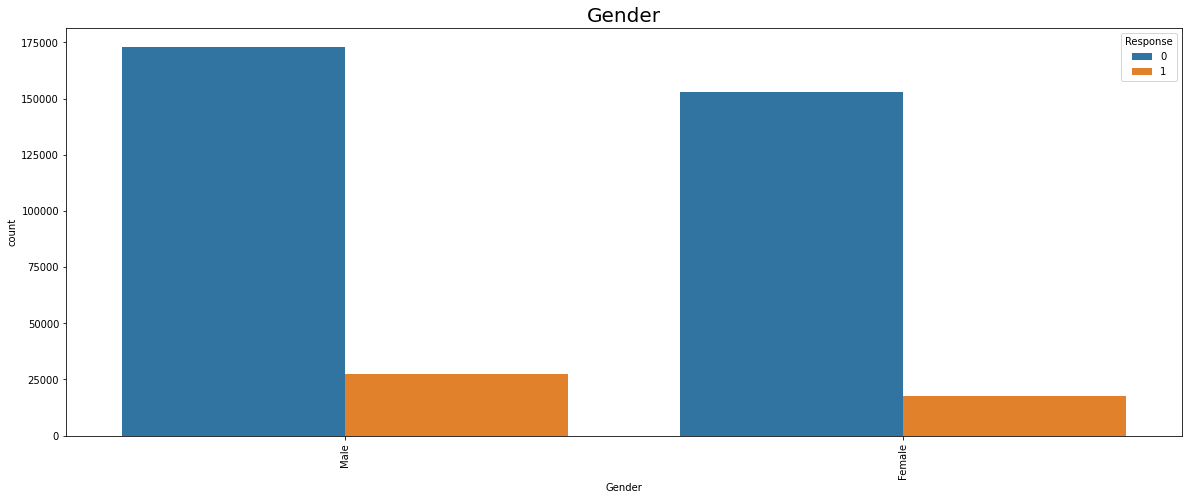

In [ ]:
plt.figure(figsize=(20,7.5)) #configuring plot size
p1 = sns.countplot(data=d,x='Gender',hue='Response') #Count plot from sea born
p1.set_xticklabels(p1.get_xticklabels(),rotation = 90) #Rotating x-labels by 90 degrees
p1.set_title("Gender", fontsize=20) #Setting title for the graph
plt.show() #Displaying graph

**Plot 2:** The following graph shows the distribution of target class between different region codes. We can see that the position conversion for insuarance is higher for region 28. There would be correlation with region 28 if we form a dummy variable column for that region.

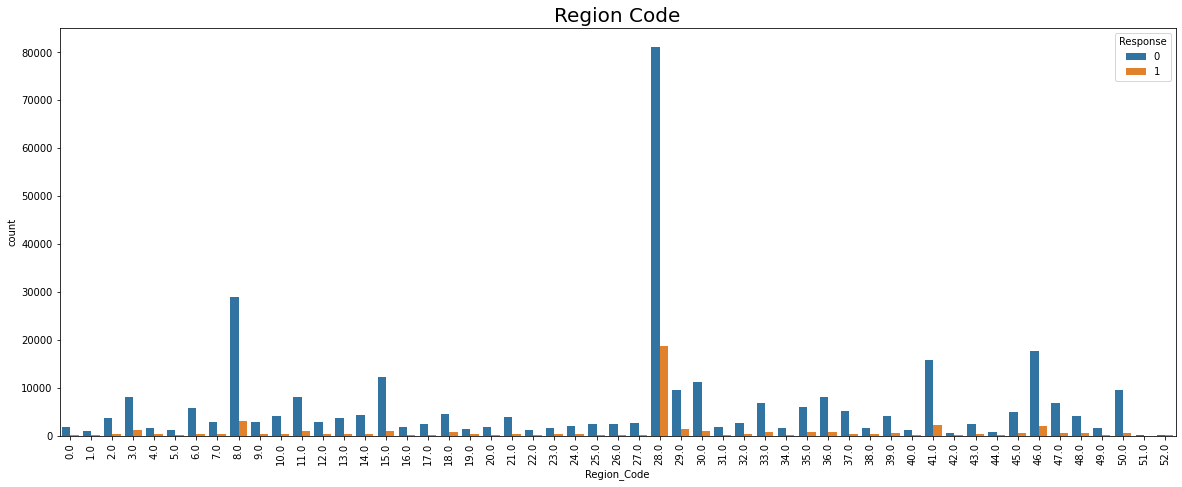

In [ ]:
plt.figure(figsize=(20,7.5)) #Configuring plot size
p2 = sns.countplot(data=d,x='Region_Code',hue='Response') #count plot using sea born module
p2.set_xticklabels(p2.get_xticklabels(),rotation = 90) #Rotating x-lables by 90 degrees
p2.set_title("Region Code", fontsize=20) #Setting title for the graph
plt.show() #Displaying plot

**Plot 3:** The following graph shows the distribution of target class between different Vehicle ages. We can see that the position conversion of >30% for vehicles with age > 2 years. It means that customers are inclined to take insurance when the vehicle is old. 

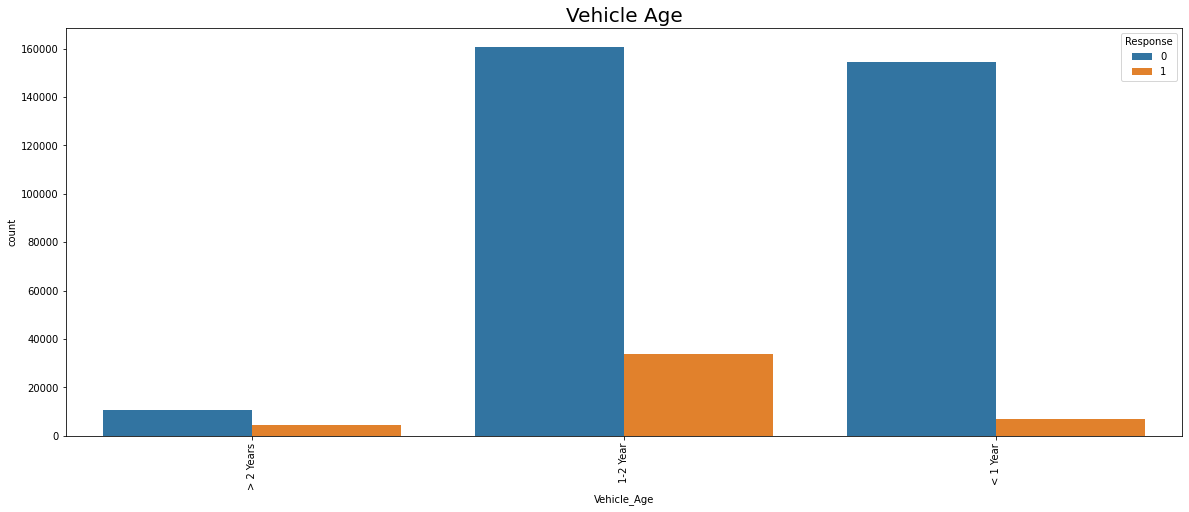

In [ ]:
plt.figure(figsize=(20,7.5)) #Configuring plot size
p3 = sns.countplot(data=d,x='Vehicle_Age',hue='Response') #count plot using sea born module
p3.set_xticklabels(p3.get_xticklabels(),rotation = 90) #Rotating x-lables by 90 degrees
p3.set_title("Vehicle Age", fontsize=20) #Setting title for the graph
plt.show() #Displaying plot 1

**Plot 4:** The following graph shows the distribution of target class for Vehicle Damage. We can see that the position conversion of >30% for vehicles with damage. It means that customers are inclined to take insurance when the vehicle was damaged. 

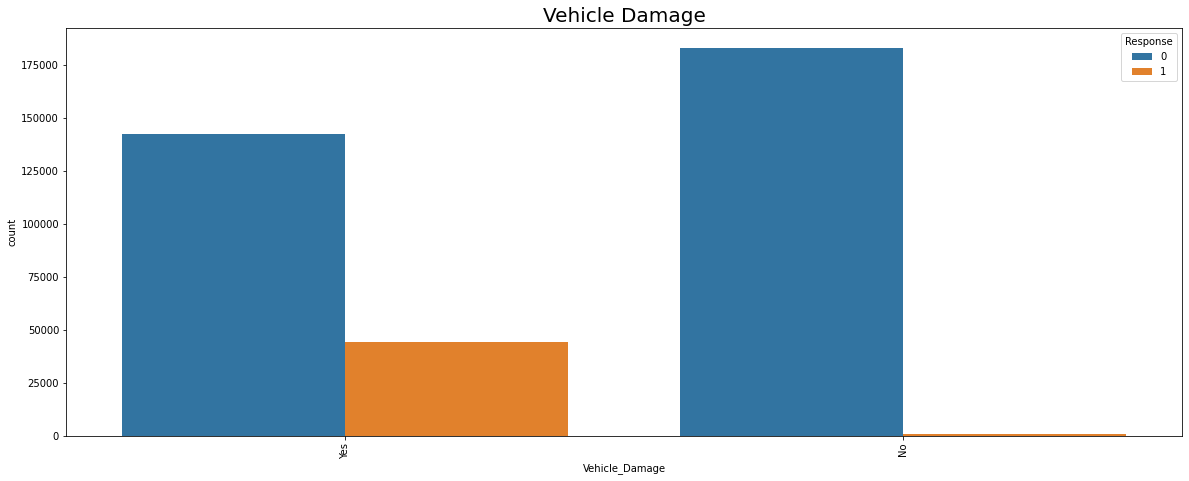

In [ ]:
plt.figure(figsize=(20,7.5)) #Configuring plot size
p4 = sns.countplot(data=d,x='Vehicle_Damage',hue='Response') #count plot using sea born module
p4.set_xticklabels(p4.get_xticklabels(),rotation = 90) #Rotating x-lables by 90 degrees
p4.set_title("Vehicle Damage", fontsize=20) #Setting title for the graph
plt.show() #Displaying plot

**Plot 5:** The following graph shows the distribution of target class for different age groups. We can see a bi-modal distribution of age (Blue bars) and Normal distribution for insurance positive class (Orange bars). We can see that the age group 35- 52 are more inclined to take the insurance

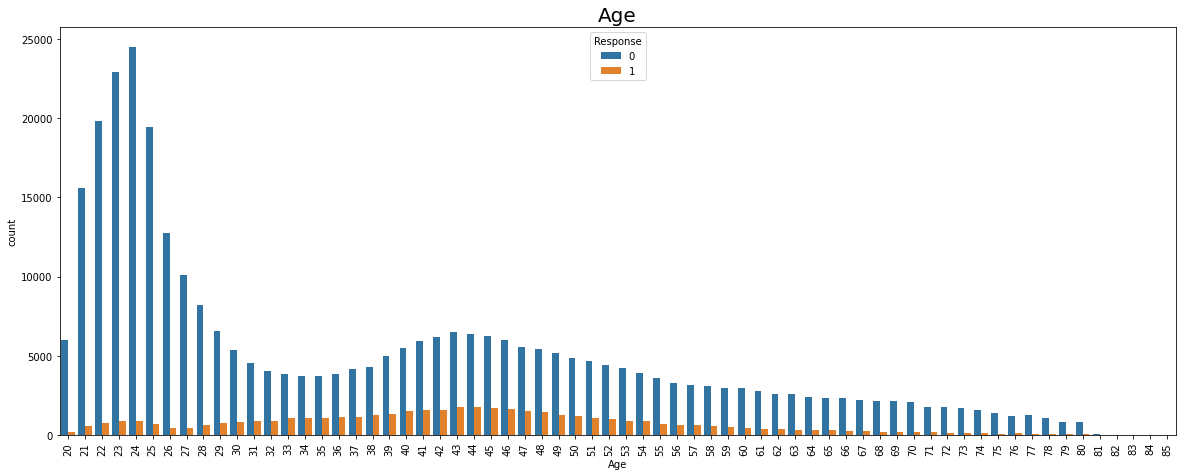

In [ ]:
plt.figure(figsize=(20,7.5))  #Configuring plot size
p5 = sns.countplot(data=d,x='Age',hue='Response') #count plot using sea born module
p5.set_xticklabels(p5.get_xticklabels(),rotation = 90) #Rotating x-lables by 90 degrees
p5.set_title("Age", fontsize=20) #Setting title for the graph
plt.show() #Displaying plot

**Plot 6:** The following graph shows the distribution of target class for Driving License. All customers have driving license and could not see much correlation. 

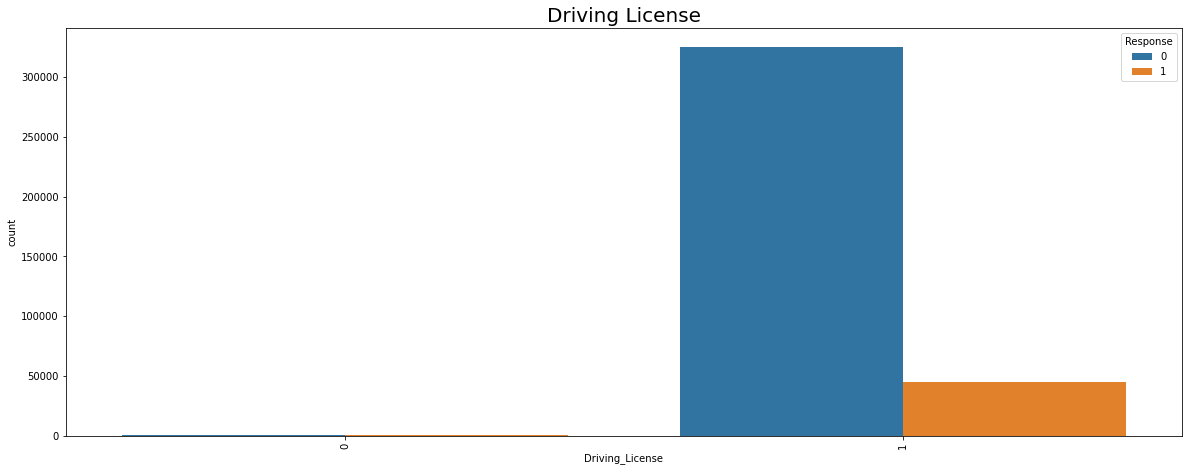

In [ ]:
plt.figure(figsize=(20,7.5)) #Configuring plot size
p6 = sns.countplot(data=d,x='Driving_License',hue='Response') #count plot using sea born module
p6.set_xticklabels(p6.get_xticklabels(),rotation = 90) #Rotating x-lables by 90 degrees
p6.set_title("Driving License", fontsize=20) #Setting title for the graph
plt.show() #Displaying plot

**Plot 7:** The following graph shows the distribution of target class for Previously Insured customers. Customers who already has insurance are not inclined to take insurance.

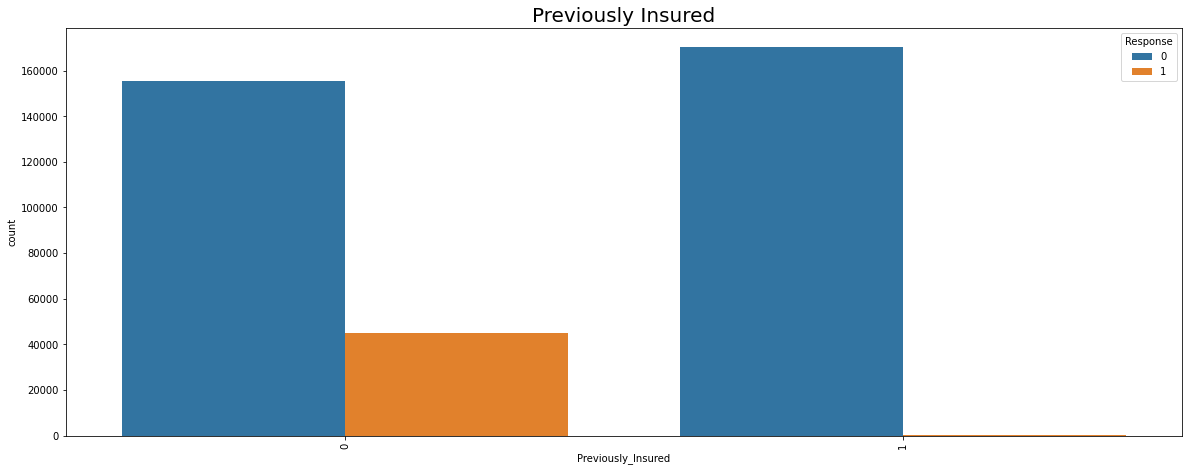

In [ ]:
plt.figure(figsize=(20,7.5)) #Configuring plot size
p7 = sns.countplot(data=d,x='Previously_Insured',hue='Response') #count plot using sea born module
p7.set_xticklabels(p7.get_xticklabels(),rotation = 90) #Rotating x-lables by 90 degrees
p7.set_title("Previously Insured", fontsize=20) #Setting title for the graph
plt.show() #Displaying plot

**Plot 8:** The following graph shows the distribution of target class for different policy sales channels. Sales channel 26 and 124 have higher conversion ratios. Channel 152 has lot of records. Forming these in to categories would have correlation. 

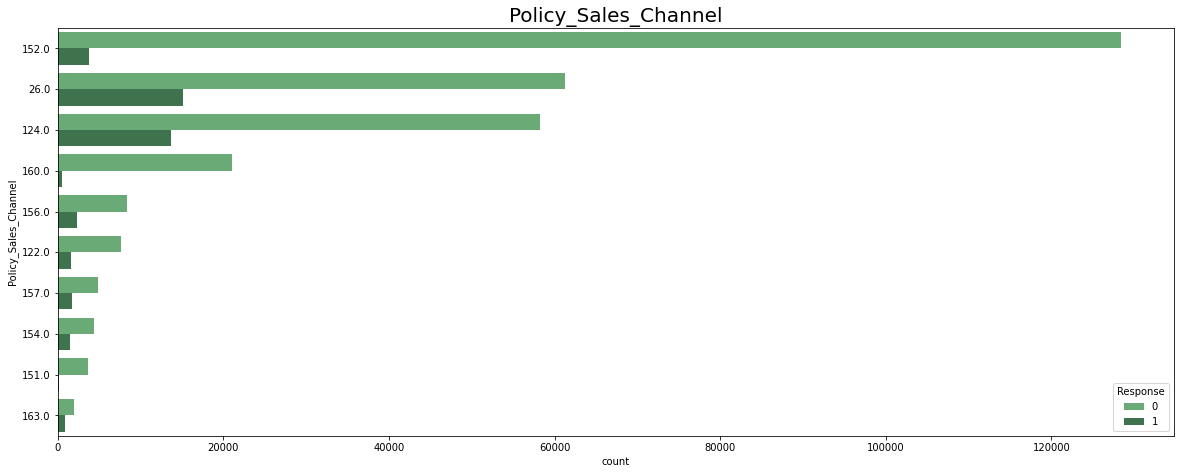

In [ ]:
plt.figure(figsize=(20,7.5)) #Configuring plot size
p8 = sns.countplot(y="Policy_Sales_Channel", hue="Response", data=d, palette="Greens_d",
              order=d.Policy_Sales_Channel.value_counts().iloc[:10].index) #count plot using sea born module
p8.set_title("Policy_Sales_Channel", fontsize=20) #Setting title for the graph
plt.show() #Displaying plot

**Forming a new dataframe (DF) for pre-processing**

In [ ]:
df = d.copy() #creating a copy of data frame 
df.info() #data dictionary of data frame(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370789 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    370789 non-null  int64  
 1   Gender                370789 non-null  object 
 2   Age                   370789 non-null  int64  
 3   Driving_License       370789 non-null  int64  
 4   Region_Code           370789 non-null  float64
 5   Previously_Insured    370789 non-null  int64  
 6   Vehicle_Age           370789 non-null  object 
 7   Vehicle_Damage        370789 non-null  object 
 8   Annual_Premium        370789 non-null  float64
 9   Policy_Sales_Channel  370789 non-null  float64
 10  Vintage               370789 non-null  int64  
 11  Response              370789 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 46.8+ MB


**Plot 9:** The following graph shows the distribution of target class for different Annual Premium bins. The conversion ratio is almost same for all bins. The bins are chosen based the values from the box plots.

In [ ]:
#Creating bins for annual premium
df.loc[(df['Annual_Premium'] <= 24000 ), 'Annual_Premium_Bins'] = '<24k'
df.loc[(df['Annual_Premium'] > 24000 ) & (df['Annual_Premium'] <= 40000 ), 'Annual_Premium_Bins'] = '24k - 40k'
df.loc[(df['Annual_Premium'] > 40000 ), 'Annual_Premium_Bins'] = '> 40k'
df.head(100)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_Bins
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,> 40k
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,24k - 40k
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,24k - 40k
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,24k - 40k
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,24k - 40k
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,Female,21,1,2.0,0,< 1 Year,Yes,34274.0,152.0,79,0,24k - 40k
99,100,Female,24,1,7.0,1,< 1 Year,Yes,2630.0,160.0,68,0,<24k
100,101,Male,52,1,28.0,1,1-2 Year,No,36033.0,26.0,92,0,24k - 40k
101,102,Male,24,1,3.0,1,< 1 Year,No,28139.0,152.0,52,0,24k - 40k


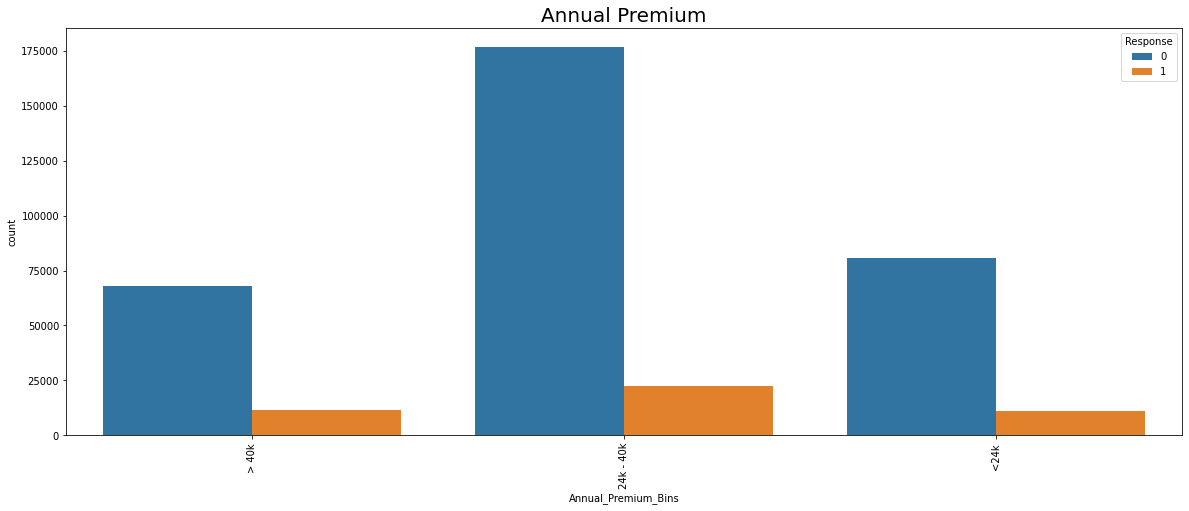

In [ ]:
plt.figure(figsize=(20,7.5))
p9 = sns.countplot(data=df,x='Annual_Premium_Bins',hue='Response')
p9.set_xticklabels(p9.get_xticklabels(),rotation = 90)
p9.set_title("Annual Premium", fontsize=20)
plt.show()

**Plot 10:** The following graph shows the distribution of target class for different Vintage bins. The conversion ratio is almost same for all bins. The bins are chosen based the values from the box plots.

In [ ]:
#Creating bins for vintage
df.loc[(df['Vintage'] <= 82 ), 'Vintage_Bins'] = '< 82'
df.loc[(df['Vintage'] > 82 ) & (df['Vintage'] <= 154 ), 'Vintage_Bins'] = '83 - 154'
df.loc[(df['Vintage'] > 154 ), 'Vintage_Bins'] = '> 154'
df.head(100)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_Bins,Vintage_Bins
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,> 40k,> 154
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,24k - 40k,> 154
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,24k - 40k,< 82
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,24k - 40k,> 154
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,24k - 40k,< 82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,Female,21,1,2.0,0,< 1 Year,Yes,34274.0,152.0,79,0,24k - 40k,< 82
99,100,Female,24,1,7.0,1,< 1 Year,Yes,2630.0,160.0,68,0,<24k,< 82
100,101,Male,52,1,28.0,1,1-2 Year,No,36033.0,26.0,92,0,24k - 40k,83 - 154
101,102,Male,24,1,3.0,1,< 1 Year,No,28139.0,152.0,52,0,24k - 40k,< 82


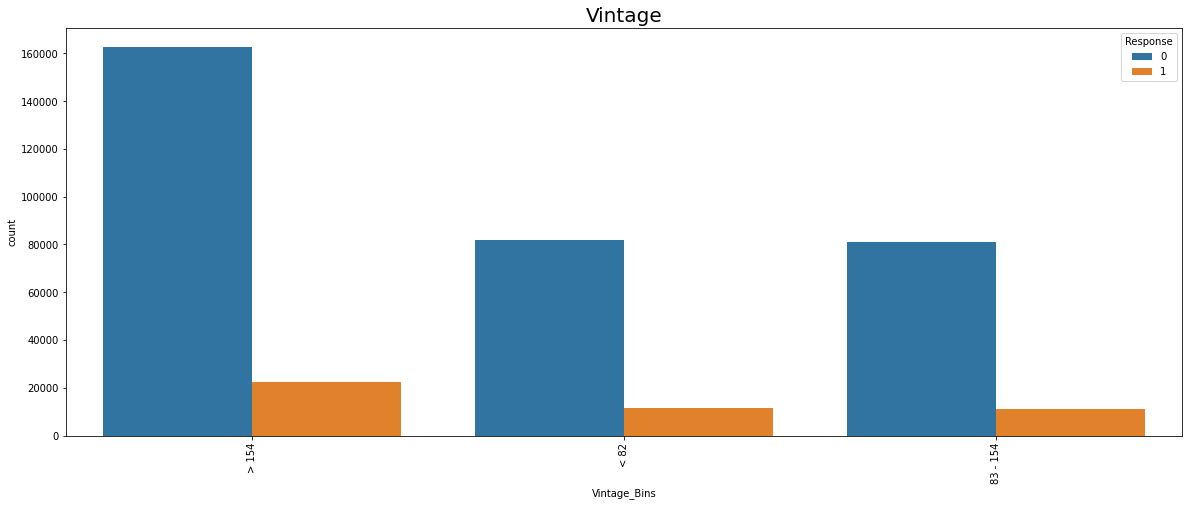

In [ ]:
plt.figure(figsize=(20,7.5))
p10 = sns.countplot(data=df,x='Vintage_Bins',hue='Response')
p10.set_xticklabels(p10.get_xticklabels(),rotation = 90)
p10.set_title("Vintage", fontsize=20)
plt.show()

**Creating dummy variables for Gender, Vehicle Damage, Region code (28), Vehicle Age, Age, Policy Sales Channel.  This will help us to determine correlations.**

In [ ]:
#Gender changes from "male" and "female" to 1 and 0
df['Gender']=df['Gender'].replace({'Male':1,'Female':0})
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_Bins,Vintage_Bins
0,1,1,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,> 40k,> 154
1,2,1,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,24k - 40k,> 154
2,3,1,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,24k - 40k,< 82
3,4,1,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,24k - 40k,> 154
4,5,0,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,24k - 40k,< 82


In [ ]:
#Converting the unique values for Vehicle_Damage and Vehicle_Age to integers
df['Vehicle_Damage'].replace({'Yes':1,'No':0},inplace=True)
df['Vehicle_Age']=df['Vehicle_Age'].replace({'< 1 Year':1,'1-2 Year':2, '> 2 Years':3})
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_Bins,Vintage_Bins
0,1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1,> 40k,> 154
1,2,1,76,1,3.0,0,2,0,33536.0,26.0,183,0,24k - 40k,> 154
2,3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1,24k - 40k,< 82
3,4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0,24k - 40k,> 154
4,5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0,24k - 40k,< 82


In [ ]:
#Creating a dummy variable for Region 28 as our analysis shows it has a significantly different relationship to the target
df['Region_28'] = df['Region_Code'].apply(lambda x: 1 if x == 28 else 0)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_Bins,Vintage_Bins,Region_28
0,1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1,> 40k,> 154,1
1,2,1,76,1,3.0,0,2,0,33536.0,26.0,183,0,24k - 40k,> 154,0
2,3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1,24k - 40k,< 82,1
3,4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0,24k - 40k,> 154,0
4,5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0,24k - 40k,< 82,0


In [ ]:
#Creating a dummy variable for Vehicle_Age as our analysis shows vehcile age of 3 (> 2 years) has a significantly different relationship to the target
df['Vehicle_Age_2'] = df['Vehicle_Age'].apply(lambda x: 1 if x == 3 else 0)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_Bins,Vintage_Bins,Region_28,Vehicle_Age_2
0,1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1,> 40k,> 154,1,1
1,2,1,76,1,3.0,0,2,0,33536.0,26.0,183,0,24k - 40k,> 154,0,0
2,3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1,24k - 40k,< 82,1,1
3,4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0,24k - 40k,> 154,0,0
4,5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0,24k - 40k,< 82,0,0


In [ ]:
#Applying bins to Age field based off of prior EDA work
df.loc[df['Age'] <= 27, 'Age_Cat'] = 1
df.loc[(df['Age'] >= 28) & (df['Age'] <= 36), 'Age_Cat'] = 2
df.loc[(df['Age'] >= 36) , 'Age_Cat'] = 3
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_Bins,Vintage_Bins,Region_28,Vehicle_Age_2,Age_Cat
0,1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1,> 40k,> 154,1,1,3.0
1,2,1,76,1,3.0,0,2,0,33536.0,26.0,183,0,24k - 40k,> 154,0,0,3.0
2,3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1,24k - 40k,< 82,1,1,3.0
3,4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0,24k - 40k,> 154,0,0,1.0
4,5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0,24k - 40k,< 82,0,0,2.0


In [ ]:
#Binning Policy_Sales_Channel based off of prior EDA work
df.loc[df['Policy_Sales_Channel'].isin([26.0, 124.0]), 'PSC'] = 1
#df.loc[df['Policy_Sales_Channel'].isin([152, 156]), 'PSC'] = 2
df['PSC'].fillna(value = 0, inplace = True)
df.head(100)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_Bins,Vintage_Bins,Region_28,Vehicle_Age_2,Age_Cat,PSC
0,1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1,> 40k,> 154,1,1,3.0,1.0
1,2,1,76,1,3.0,0,2,0,33536.0,26.0,183,0,24k - 40k,> 154,0,0,3.0,1.0
2,3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1,24k - 40k,< 82,1,1,3.0,1.0
3,4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0,24k - 40k,> 154,0,0,1.0,0.0
4,5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0,24k - 40k,< 82,0,0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,0,21,1,2.0,0,1,1,34274.0,152.0,79,0,24k - 40k,< 82,0,0,1.0,0.0
99,100,0,24,1,7.0,1,1,1,2630.0,160.0,68,0,<24k,< 82,0,0,1.0,0.0
100,101,1,52,1,28.0,1,2,0,36033.0,26.0,92,0,24k - 40k,83 - 154,1,0,3.0,1.0
101,102,1,24,1,3.0,1,1,0,28139.0,152.0,52,0,24k - 40k,< 82,0,0,1.0,0.0


##Review correlation to target variable (Response)

**Before Applying Data Transformations. We used Data Frame (d) to form this correlation graph.**

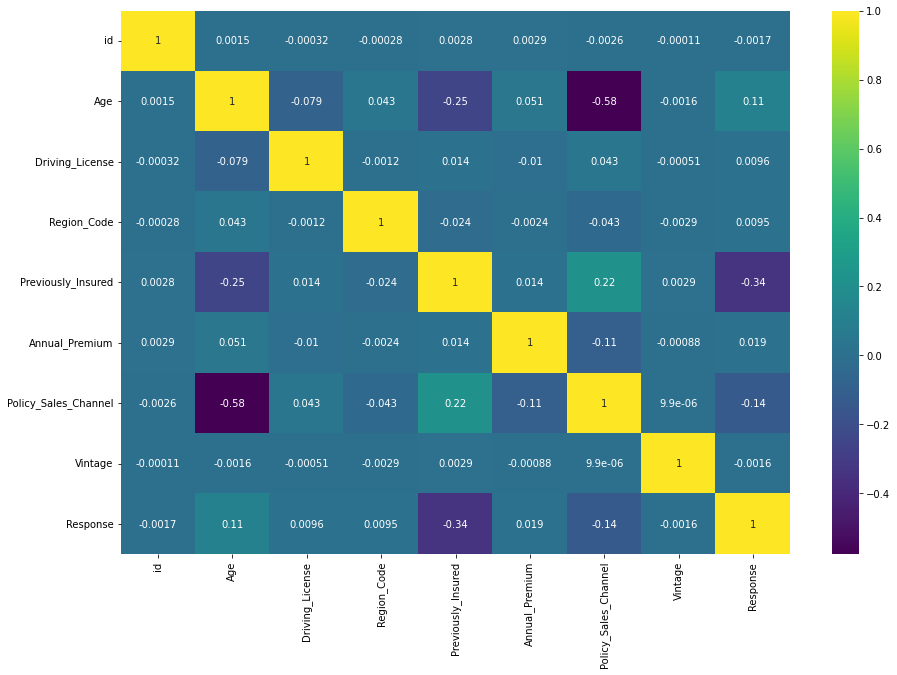

In [ ]:
plt.figure(figsize=(15,10)) #Configuring plot size
sns.heatmap(d.corr(),annot=True, cmap='viridis') #Heatmap for correlation co-efficients

**Before Applying Data Transformations. We used Data Frame (d) to form this correlation graph.**


**There is an improvement in correlation after binning. We can see the correlation of PSC, Age_Cat, Vehicle_Age_2, and Region_28**

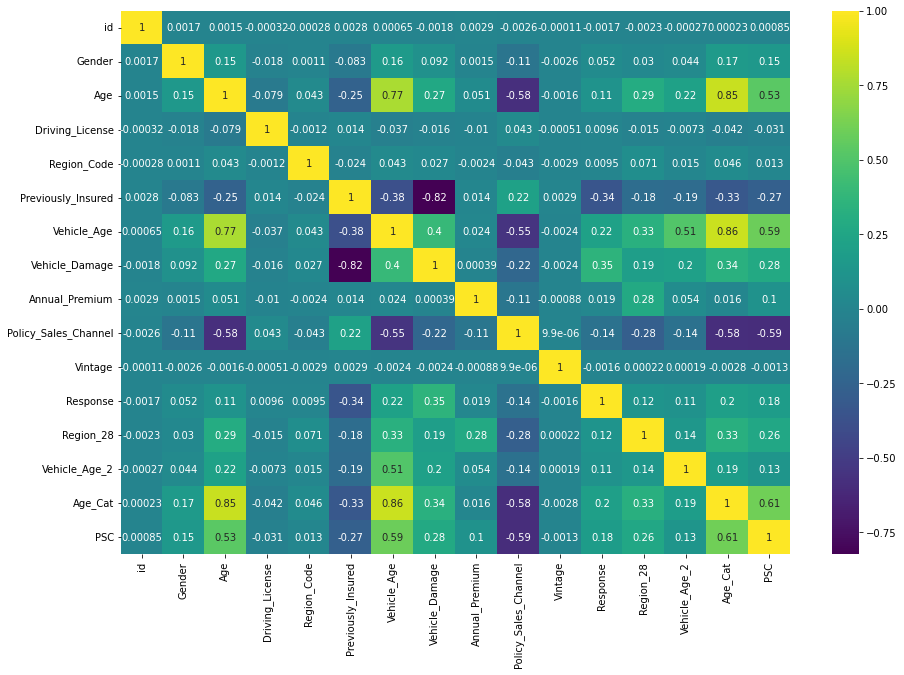

In [ ]:
plt.figure(figsize=(15,10)) #Configuring plot size
sns.heatmap(df.corr(),annot=True, cmap='viridis') #Heatmap for correlation co-efficients 

In [ ]:
#Cross-checking if we formed any null values in data frame
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
Annual_Premium_Bins     0
Vintage_Bins            0
Region_28               0
Vehicle_Age_2           0
Age_Cat                 0
PSC                     0
dtype: int64

##Modeling

**The first step is to choose the x variables and y variables which has good correlation.**

In [ ]:
X = df[[ 'Previously_Insured', 'Vehicle_Age_2', 'Age_Cat',
                              'Vehicle_Damage', 'Annual_Premium', 'Vintage', 'PSC', 'Region_28']] #These are the x-features

y=df['Response'] #This is target variable
print(y.shape) #shape of y

(370789,)


In [ ]:
X.columns #Print columns selected for x-features

Index(['Previously_Insured', 'Vehicle_Age_2', 'Age_Cat', 'Vehicle_Damage',
       'Annual_Premium', 'Vintage', 'PSC', 'Region_28'],
      dtype='object')

#Apply Synthetic Minority Oversampling Technique
Our target variable is imbalanced. There are significantly more responses of 0 than 1. To balance this we are using the synthetic minority oversampling technique, or SMOTE. Using this technique, we are oversampling for response =1 to gain more records and undersampling for response =0. Since we began with around 380k records we were not concerned with losing some response =0 records to balance the ratio between response 1 and response 0.

Splitting the data between train (70%) and text(30%)

In [ ]:
samplers = [SMOTE(random_state=0), SMOTEENN(0.62,random_state=0), SMOTETomek(random_state=0)] #Three different SMOTE functions
X_comb, y_comb = samplers[1].fit_resample(X, y) #chose the second one
X_train, X_test, y_train, y_test = train_test_split(X_comb, y_comb, test_size=0.3, random_state=42)  #Data split between train and test
print(X_train.shape) #Printing shape
print(X_test.shape)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.62 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


(182871, 8)
(78374, 8)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


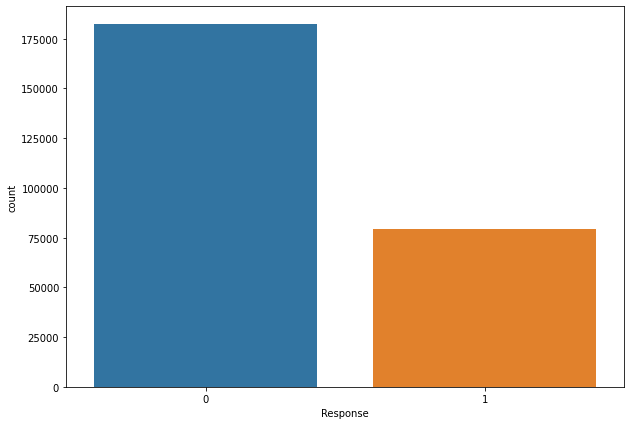

In [ ]:
#Ensure target variable is more balanced as a result of SMOTE
figs, axes = plt.subplots(figsize=(10,7))
plot = sns.countplot(y_comb)
plt.show()

In [ ]:
y_train #Printing y_train values

94567     0
89269     0
96217     0
159627    0
180016    0
         ..
259178    1
103694    0
131932    0
146867    0
121958    0
Name: Response, Length: 182871, dtype: int64

**Creating a user-defined function to give output of prediction probabilities. This function will be used for plotting ROC curves**

In [ ]:
def pred_prob(clf, data): 
    y_pred = []
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

##Logistic Regression

In [ ]:
# Fit logistic regression
model = LogisticRegression(C=10000.0, random_state=0) #Assigning Logistic regression model to a varibale
model.fit(X_train, y_train) #training the model x_train and y_train 

# Slide 9
y_pred = model.predict(X_test) #Predicting y values based on x_test data

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred)) #Printing accuracy score
print("Classification Report is:\n",classification_report(y_test,y_pred)) #Printing classification report 
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred)) #printing confusion matrix
print("Training Score:\n",model.score(X_test,y_test)*100) #scoring the model
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred)) #printing mean squared error
print("R2 score is:\n",r2_score(y_test,y_pred)) #Print r2 score
print(model.get_params()) 
print(accuracy_score(y_test,y_pred)*100)

Accuracy: 0.75
Classification Report is:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81     54405
           1       0.58      0.74      0.65     23969

    accuracy                           0.75     78374
   macro avg       0.72      0.75      0.73     78374
weighted avg       0.78      0.75      0.76     78374

Confusion Matrix:
 [[41332 13073]
 [ 6131 17838]]
Training Score:
 75.49697603797178
Mean Squared Error:
 0.24503023962028223
R2 score is:
 -0.15418381466435505
{'C': 10000.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
75.49697603797178


##Random Forest

In [ ]:
model=RandomForestClassifier()
model.fit(X_train,y_train)


y_pred=model.predict(X_test)
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",model.score(X_test,y_test)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))
print(model.get_params())
print(accuracy_score(y_test,y_pred)*100)

Classification Report is:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     54405
           1       0.85      0.84      0.84     23969

    accuracy                           0.90     78374
   macro avg       0.89      0.89      0.89     78374
weighted avg       0.90      0.90      0.90     78374

Confusion Matrix:
 [[50858  3547]
 [ 3921 20048]]
Training Score:
 90.47132977773241
Mean Squared Error:
 0.09528670222267589
R2 score is:
 0.551164094568142
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
90.47132977773241


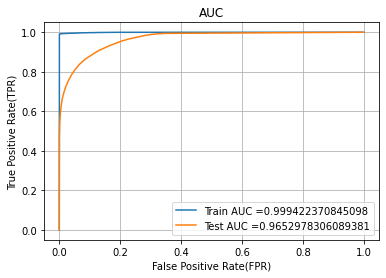

In [ ]:
y_tr_predict=pred_prob( model,X_train)   
y_te_predict=pred_prob( model,X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_tr_predict)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_te_predict)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

##KNN

In [ ]:
model=KNeighborsClassifier()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",model.score(X_test,y_test)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))
print(model.get_params())
print(accuracy_score(y_test,y_pred)*100)

Classification Report is:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94     54405
           1       0.85      0.86      0.85     23969

    accuracy                           0.91     78374
   macro avg       0.89      0.90      0.89     78374
weighted avg       0.91      0.91      0.91     78374

Confusion Matrix:
 [[50743  3662]
 [ 3380 20589]]
Training Score:
 91.01487738280552
Mean Squared Error:
 0.08985122617194478
R2 score is:
 0.576767213972798
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
91.01487738280552


##Decision Tree

In [ ]:
model= tree.DecisionTreeClassifier(max_depth = 12)
model.fit(X_train,y_train)

y_pred=model.predict(X_test)
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",model.score(X_test,y_test)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))
print(model.get_params())
print(accuracy_score(y_test,y_pred)*100)

Classification Report is:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90     54405
           1       0.79      0.77      0.78     23969

    accuracy                           0.87     78374
   macro avg       0.85      0.84      0.84     78374
weighted avg       0.87      0.87      0.87     78374

Confusion Matrix:
 [[49495  4910]
 [ 5490 18479]]
Training Score:
 86.73029320948274
Mean Squared Error:
 0.13269706790517263
R2 score is:
 0.37494731969853723
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
86.73029320948274


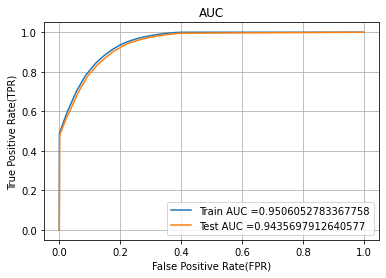

In [ ]:
y_tr_predict=pred_prob( model,X_train)   
y_te_predict=pred_prob( model,X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_tr_predict)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_te_predict)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

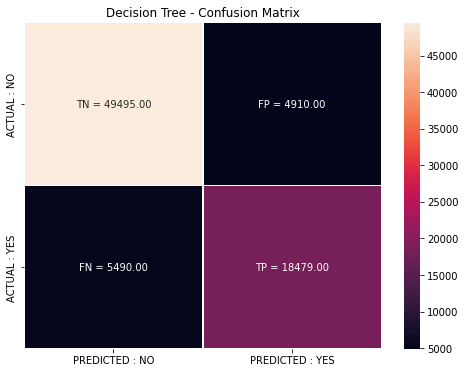

In [ ]:
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig = plt.figure(figsize= [8,6])
ax1 = fig.add_subplot(111)
#best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm = confusion_matrix(y_test,y_pred)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), cm.flatten())])).reshape(2,2)
sns.heatmap(cm, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '')
ax1.set_title('Decision Tree - Confusion Matrix')
plt.show(ax1)

In [ ]:
X_VAR=list(X.columns) #Forming X_VAR variable a form a visual decision tree
X_VAR

['Previously_Insured',
 'Vehicle_Age_2',
 'Age_Cat',
 'Vehicle_Damage',
 'Annual_Premium',
 'Vintage',
 'PSC',
 'Region_28']

**Explore Decision Tree Nodes**

This plot helps us to analyze Decsion Tree splits visually

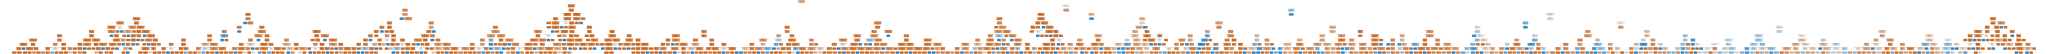

In [ ]:
dd = tree.export_graphviz(model, out_file=None,  feature_names=X_VAR, class_names=['0','1'],filled=True) #Plotting visualization graph on the data and assigning it to a variable
# Draw graph
graph = graphviz.Source(dd, format="png") 
graph

##Naive Bayes

In [ ]:
model= GaussianNB()
model.fit(X_train,y_train)
from sklearn.metrics import mean_absolute_error,mean_squared_error,confusion_matrix,r2_score,accuracy_score
y_pred=model.predict(X_test)
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",model.score(X_test,y_test)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))
print(model.get_params())
print(accuracy_score(y_test,y_pred)*100)

Classification Report is:
               precision    recall  f1-score   support

           0       0.91      0.79      0.84     54405
           1       0.63      0.83      0.72     23969

    accuracy                           0.80     78374
   macro avg       0.77      0.81      0.78     78374
weighted avg       0.83      0.80      0.81     78374

Confusion Matrix:
 [[42723 11682]
 [ 4019 19950]]
Training Score:
 79.96657054635466
Mean Squared Error:
 0.2003342945364534
R2 score is:
 0.05635075640257048
{'priors': None, 'var_smoothing': 1e-09}
79.96657054635466


#Assessment


Model Evaluation:
We chose Decision Tree as the best model for the following reasons:
1. The accuracy is higher relative to other models.
2. The accuracy from Test AUC curve is 94%
3. Precision and Recall are favorable
4. Model is easily interpretable by reviewing the above diagram

#Business Recommendations
**Use Case 1: Call Routing for Existing Policyholders**
This use case will require that predictions are generated regularly based on the latest data in the company’s system. The process associated with this use case will be initiated when an existing customer calls customer service and confirms their identity. Once the policyholder’s identity is confirmed, their cross-sell prediction will be utilized to assist the system in routing the call.
Simply making customer service and sales representatives aware of the model prediction could help them be more effective at their jobs. For example, if a customer service representative knows a caller is likely to purchase an auto policy, they may ask the seller if they are interested in speaking to the sales team several times throughout the call. The model predictions could become more integrated into the call-handling process by implementing rules based on the model predictions.
Incoming calls with a predicted response of purchasing an auto policy could be routed to efficient customer service representatives trained to initiate the cross-sell by getting the policyholder to agree to being transferred to a sales representative once their initial reason for calling has been resolved. A similar logic can be applied when the caller is routed to the sales representative. Since they have a high probability of purchasing a policy, they can be placed towards the front of the queue of incoming sales calls. They could also be routed to experienced and efficient sales agents.
Conversely, the callers with a low probability of purchasing an auto policy can be routed to customer service agents who are more skilled in selling the value-proposition of the auto product. In the unlikely chance a caller decides to speak to an auto sales agent, they could be routed to agents specifically trained to sell to difficult customers.

**Use Case 2: Marketing to Existing Policyholders**
This use case will require that predictions are generated regularly based on the latest data in the company’s system. Marketing can send advertisements for auto insurance to existing policyholders that are predicted to purchase the product. They could also integrate this into other marketing campaigns. This can be achieved by understanding which policyholders are not predicted to purchase an auto policy. Using this information, they can assess the current marketing budget and how it is being allocated. If money is being spent on those policyholders who are unlikely to convert, the Marketing team can change their strategy and allocate that money to those predicted to convert.
Another variation of this use case could involve using this information to decide which customers the sales team calls. If the model predicts a customer is likely to convert, the sales team may attempt to reach out and make the sale. This variation is dependent on company policy around cold calling.

**Use Case 3: Shape the Digital Experience**
This use case will require that predictions are generated regularly based on the latest data in the company’s system. The digital experience team can utilize model predictions to update the customer’s digital experience. This could involve having two versions of various user interfaces. One version for those unlikely to purchase an auto policy and another version for those likely to purchase.
One example would be updating the online bill payment portal. Policyholders likely to convert may see more advertisements and callouts to the auto product. Those unlikely to purchase may be shown less auto product advertisements or entirely different advertisements that are targeted to them.
Another example may be the online auto quote experience. Third-party data could be leveraged to streamline the process for policyholders who are unlikely to purchase the policy. The use of third-party data means they would need to fill out less information and therefore may actually complete the quote and purchase the policy.

**Use Case 4: Cross-Sell to New Business**
This use case will require that predictions are generated in real-time. The model predictions can be utilized when a sales representative is handling a new health insurance customer. Once the sales representative has completed the quote and closed the sale, the system will be updated with all the data needed to produce a cross-sell prediction. The model will automatically produce this prediction real-time, and it will be stored in the system. The sales representative, who is trained to sell both health and auto insurance products, will see the prediction. Based on the prediction, the representative will refer to a provided strategy from sales leadership aimed to maximize the odds of completing the sale.
For example, representatives may keep the process efficient and high-level for customers with a high likelihood to purchase an auto policy. For those customers who are unlikely to purchase, the representative may focus more on selling the product and communicating the value the customer would be receiving.
